## Data loading and preprocessing

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


p_np
1    1567
0     483
Name: count, dtype: int64


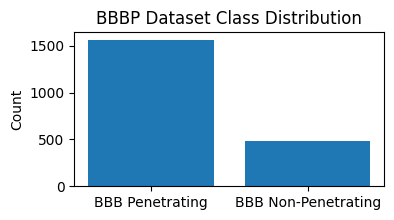

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


file_name = r"C:\Users\caleb\OneDrive\Desktop\UCLA senior year\AOS C111 - Introduction to Machine Learning for Physical Sciences\BBBP.csv"
data = pd.read_csv(file_name)

display(data.head(5))

smiles = data['smiles']
labels = data['p_np']

plt.figure(figsize=(4,2))
plt.bar(['BBB Penetrating', 'BBB Non-Penetrating'], labels.value_counts())
plt.ylabel('Count')
plt.title('BBBP Dataset Class Distribution')
print(labels.value_counts())

[21:17:53] Explicit valence for atom # 1 N, 4, is greater than permitted
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] WARNING: not removing hydrogen atom without neighbors
[21:17:53] Explicit valence for atom # 11 N, 4, is greater than pe

,MolWt,NumHDonors,NumHAcceptors,MolLogP,TPSA,NumRotatableBonds,HeavyAtomCount,RingCount,NumAromaticRings
min,28.05,0.00,0.00,-11.74,0.00,0.0,2.00,0.00,0.00
max,1879.68,24.00,33.00,10.81,662.41,35.0,132.00,16.00,7.00
mean,344.54,1.55,4.58,2.32,70.73,4.2,24.05,2.99,1.41
median,324.41,1.00,4.00,2.47,55.12,4.0,23.00,3.00,1.00


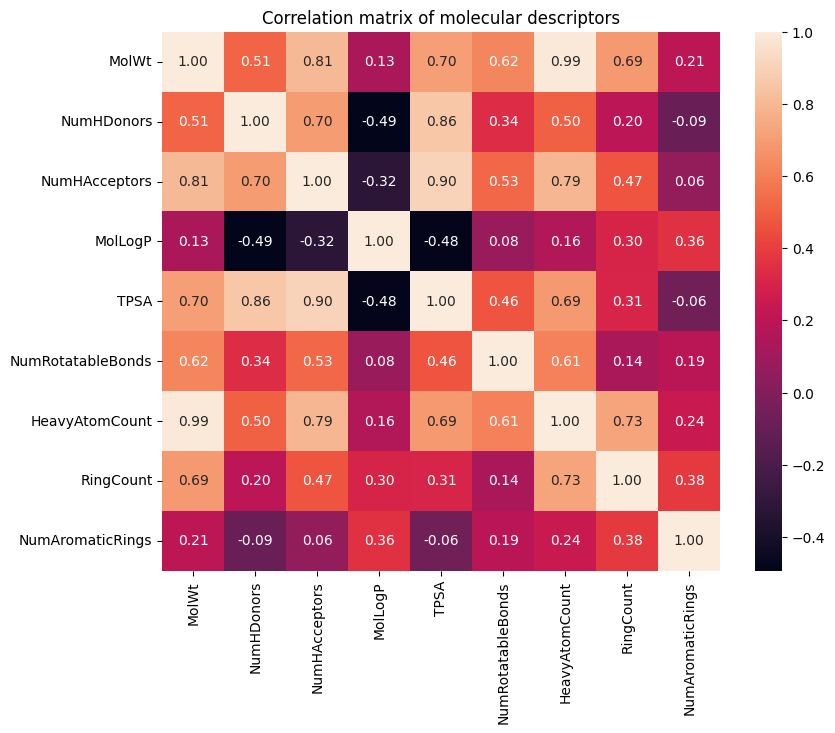

,num,name,p_np,smiles,MolWt,NumHDonors,NumHAcceptors,MolLogP,TPSA,NumRotatableBonds,HeavyAtomCount,RingCount,NumAromaticRings
1896,1900,metaclazepam,1,C1=C(Br)C=CC2=C1C(=NCC(N2C)COC)C3=CC=CC=C3Cl,393.712,0.0,3.0,4.4047,24.83,3.0,23.0,3.0,2.0
1868,1872,indalpine,1,C1=CC=CC2=C1C(=C[NH]2)CCC3CCNCC3,228.339,2.0,1.0,3.1001,27.82,3.0,17.0,3.0,2.0
1386,1390,mometasone(mometasone-furoate),1,[C@H]34[C@H]2[C@@](Cl)([C@@]1(C(=CC(=O)C=C1)CC...,427.368,2.0,4.0,3.4115,74.60,2.0,28.0,4.0,0.0
2011,2015,ticabesone(ticabesone-propionate),1,[C@]14([C@](OC(=O)CC)([C@@H](CC1C3[C@@](F)(C2(...,482.589,1.0,6.0,4.1328,80.67,3.0,33.0,4.0,0.0


(2039, 9)
(2039,)
shape of X_train:
 (1427, 9)
shape of y_train:
 (1427,)

shape of X_test:
 (612, 9)
shape of y_test:
 (612,)


In [105]:
descriptor_list = [Descriptors.MolWt, Descriptors.NumHDonors, Descriptors.NumHAcceptors, Descriptors.MolLogP, 
                   Descriptors.TPSA, Descriptors.NumRotatableBonds, Descriptors.HeavyAtomCount, 
                   Descriptors.RingCount, Descriptors.NumAromaticRings]

descriptor_names = ['MolWt', 'NumHDonors', 'NumHAcceptors', 'MolLogP', 
                    'TPSA', 'NumRotatableBonds', 'HeavyAtomCount', 
                    'RingCount', 'NumAromaticRings']

# Extract molecular descriptors
def get_descriptors(smiles_key):
    mol = Chem.MolFromSmiles(smiles_key)
    if mol is None:
        return [None]  * len(descriptor_list)
    return [desc(mol) for desc in descriptor_list]  # shape (# descriptors,)

desc_values = []   # shape (N, # descriptors)
for s in data['smiles']: 
    desc_values.append(get_descriptors(s))

# Summary statistics and correlation matrix of descriptors
desc_values_df = pd.DataFrame(desc_values, columns=descriptor_names)
desc_summary_stats = desc_values_df.agg(['min', 'max', 'mean', 'median']).round(2)
display(desc_summary_stats)

corr_matrix = desc_values_df.corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation matrix of molecular descriptors")
plt.show()


# Add descriptors to data dataframe
data_with_descs = pd.concat([data, desc_values_df], axis=1)
data_with_descs = data_with_descs.dropna() # dropped 11 rows with invalid SMILES


display(data_with_descs.sample(4))
X_data = data_with_descs.drop(columns=['num', 'name', 'smiles', 'p_np'], axis=1).values    # shape (N, # descriptors)
y_data = data_with_descs['p_np'].values                                                    # shape (N,)
y_data = y_data

print(X_data.shape)
print(y_data.shape)  

# Train test split
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size, random_state=0)

print("shape of X_train:")
print("", X_train.shape)
print("shape of y_train:")
print("", y_train.shape)
print()
print("shape of X_test:")
print("", X_test.shape)
print("shape of y_test:")
print("", y_test.shape)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest Classifier

Accuracy: 0.886
Balanced Accuracy: 0.820
F1 score:, 0.927
ROC-AUC: 0.903


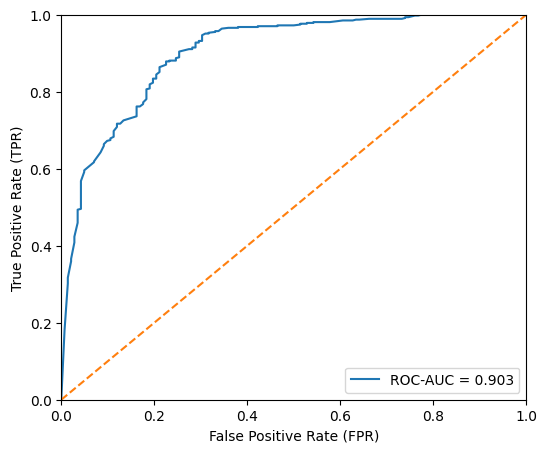

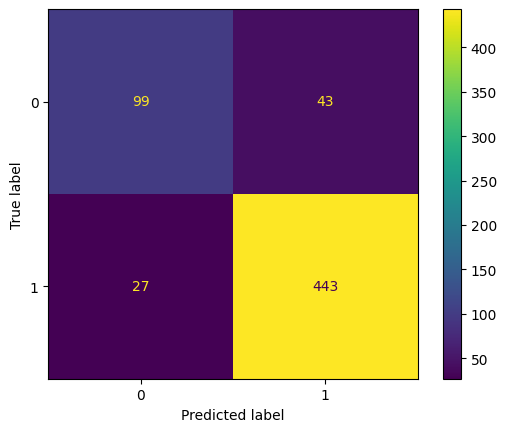

([<matplotlib.axis.XTick at 0x20a405909d0>,
 [Text(0, 0, 'TPSA'),
  Text(1, 0, 'MolLogP'),
  Text(2, 0, 'NumHDonors'),
  Text(3, 0, 'MolWt'),
  Text(4, 0, 'HeavyAtomCount'),
  Text(5, 0, 'NumHAcceptors'),
  Text(6, 0, 'NumRotatableBonds'),
  Text(7, 0, 'NumAromaticRings'),
  Text(8, 0, 'RingCount')])

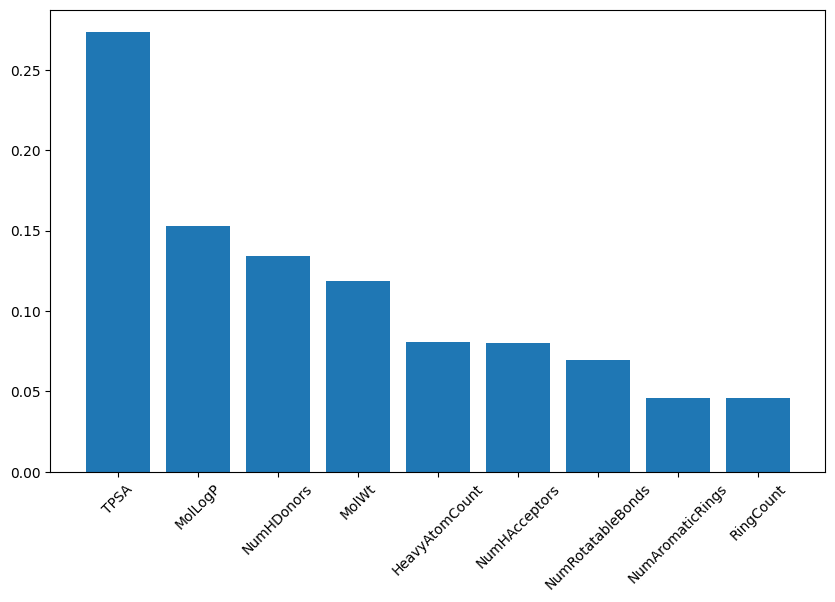

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score


rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=0)

def perform_classification(model, X_tr, X_te, y_tr, y_te):  # To be honest, this function is not very well written and becomes redundant, but I wanted practice writing functions, lol
    
    # Fit and predict
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    y_score = model.predict_proba(X_te)[:, 1]   # y_score is the predicted probability that the label is 1

    # Accuracy
    accuracy = accuracy_score(y_te, y_pred)
    print(f"Accuracy: {accuracy:.3f}")
    balanced_acc = balanced_accuracy_score(y_te, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.3f}")

    f1 = f1_score(y_te, y_pred)
    print(f"F1 score:, {f1:.3f}")

    # ROC-AUC
    fpr, tpr, thresholds = roc_curve(y_te, y_score)
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC: {roc_auc:.3f}")
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
    plt.legend([f'ROC-AUC = {roc_auc:.3f}'], loc='lower right')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_te, y_pred)
    
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

    return accuracy, balanced_acc, f1, roc_auc

perform_classification(rf, X_train, X_test, y_train, y_test)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X_data.shape[1]), importances[indices], align='center')
plt.xticks(range(X_data.shape[1]), np.array(descriptor_names)[indices], rotation=45)

### Note that in the report, this graph is omitted in favor of the k-fold CV version below. 

### K-FOLD RF

fold  1 : ROC-AUC:, 0.877
fold  2 : ROC-AUC:, 0.854
fold  3 : ROC-AUC:, 0.896
fold  4 : ROC-AUC:, 0.879
fold  5 : ROC-AUC:, 0.885
Accuracy: 0.877
Balanced Accuracy: 0.802
F1 score: 0.9219562955254943
ROC-AUC: 0.892


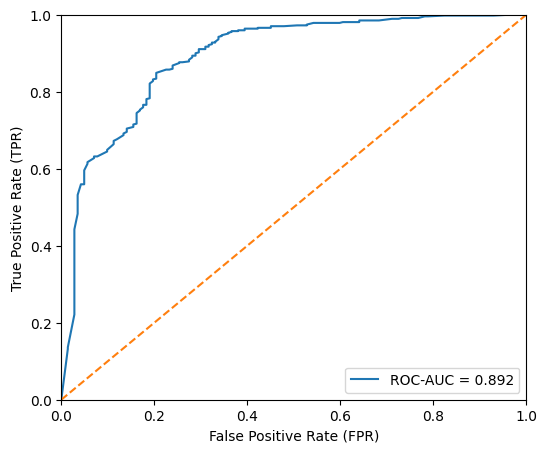

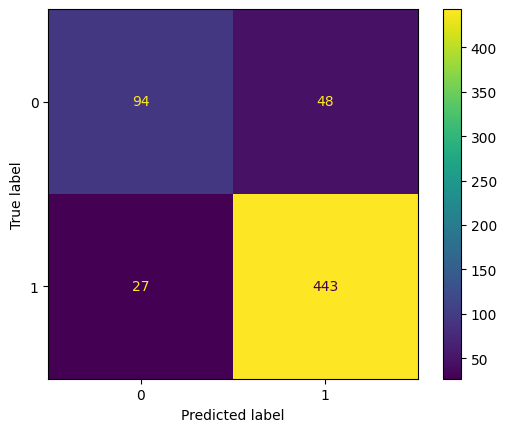

([<matplotlib.axis.XTick at 0x20a4052e190>,
 [Text(0, 0, 'TPSA'),
  Text(1, 0, 'MolLogP'),
  Text(2, 0, 'NumHDonors'),
  Text(3, 0, 'MolWt'),
  Text(4, 0, 'HeavyAtomCount'),
  Text(5, 0, 'NumHAcceptors'),
  Text(6, 0, 'NumRotatableBonds'),
  Text(7, 0, 'RingCount'),
  Text(8, 0, 'NumAromaticRings')])

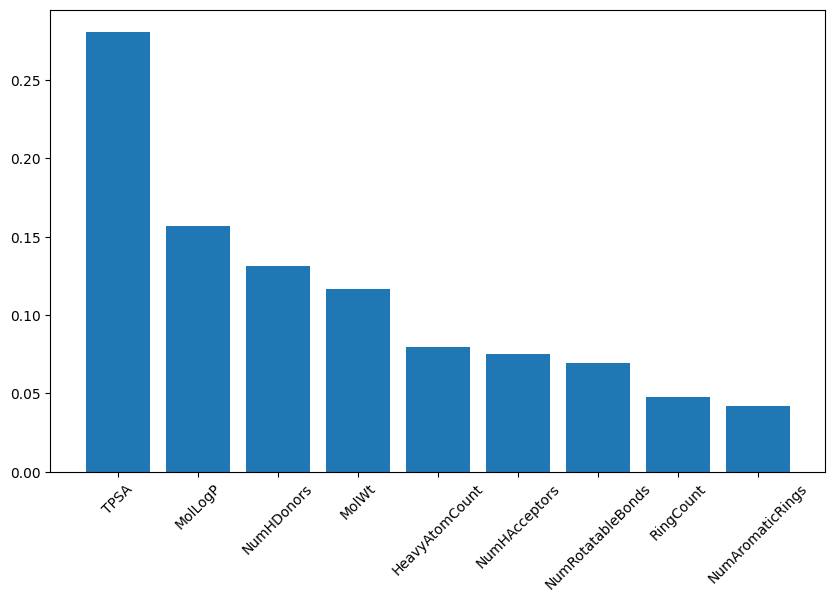

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score
from sklearn.model_selection import StratifiedKFold
import copy

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=0)

def perform_kfold_cv(model, X_tr, X_te, y_tr, y_te):
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    k = 1 
    best_roc_auc = 0

    for idx_train, idx_val in kf.split(X_tr, y_tr):
        X_tr_k = X_tr[idx_train]
        y_tr_k = y_tr[idx_train]
        
        X_val = X_tr[idx_val]
        y_val = y_tr[idx_val]
        
        model.fit(X_tr_k, y_tr_k)
        y_pred_val = model.predict(X_val)
        y_score = model.predict_proba(X_val)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_val, y_score)
        roc_auc = auc(fpr, tpr)

        print("fold ", k, f": ROC-AUC:, {roc_auc:.3f}")
        k = k + 1
        
        if roc_auc > best_roc_auc:
            best_model = copy.deepcopy(model)
            best_roc_auc = roc_auc

    y_pred = best_model.predict(X_te)
    y_score = best_model.predict_proba(X_te)[:, 1]

    # Accuracy
    accuracy = accuracy_score(y_te, y_pred)
    print(f"Accuracy: {accuracy:.3f}")
    balanced_acc = balanced_accuracy_score(y_te, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.3f}")

    f1 = f1_score(y_te, y_pred)
    print("F1 score:", f1)

    # ROC-AUC
    fpr, tpr, thresholds = roc_curve(y_te, y_score)
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC: {roc_auc:.3f}")
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
    plt.legend([f'ROC-AUC = {roc_auc:.3f}'], loc='lower right')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_te, y_pred)
    
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

    return best_model

best_rf = perform_kfold_cv(rf, X_train, X_test, y_train, y_test)

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X_data.shape[1]), importances[indices], align='center')
plt.xticks(range(X_data.shape[1]), np.array(descriptor_names)[indices], rotation=45)





## Logistic Regression

Accuracy: 0.791
Balanced Accuracy: 0.778
F1 score:, 0.855
ROC-AUC: 0.839


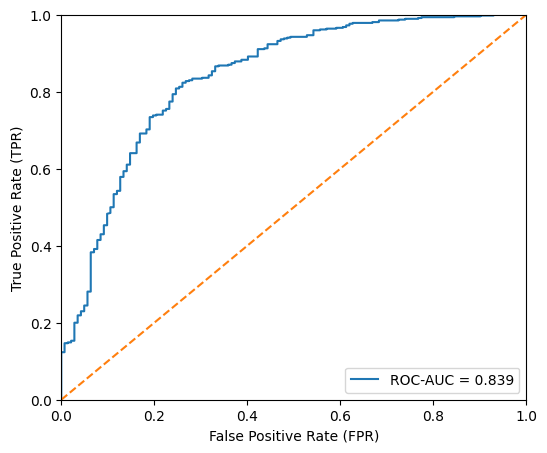

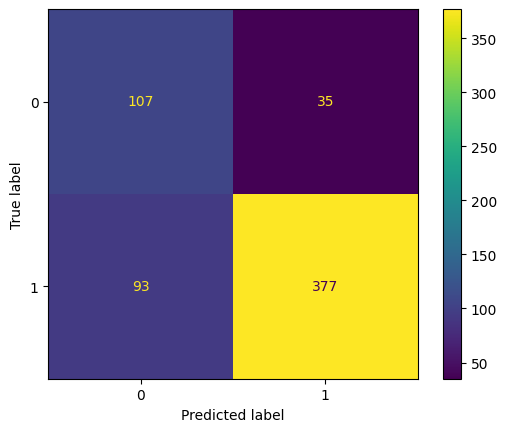

(0.7908496732026143, 0.7778243931675157, 0.854875283446712, 0.8388148037159125)

In [108]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000, random_state=0)

perform_classification(lr, X_train, X_test, y_train, y_test)

## PCA

Text(0, 0.5, 'Cumulative Explained Variance')

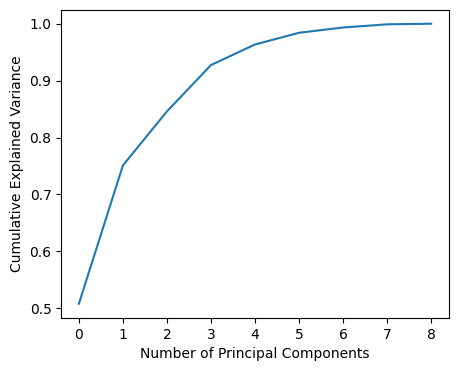

In [109]:
from sklearn.decomposition import PCA

pca9 = PCA(n_components=9)
X_train_pca9 = pca9.fit_transform(X_train_scaled)
X_test_pca9 = pca9.transform(X_test_scaled)

pca9_evr = pca9.explained_variance_ratio_
plt.figure(figsize=(5, 4))
plt.plot(np.cumsum(pca9_evr))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

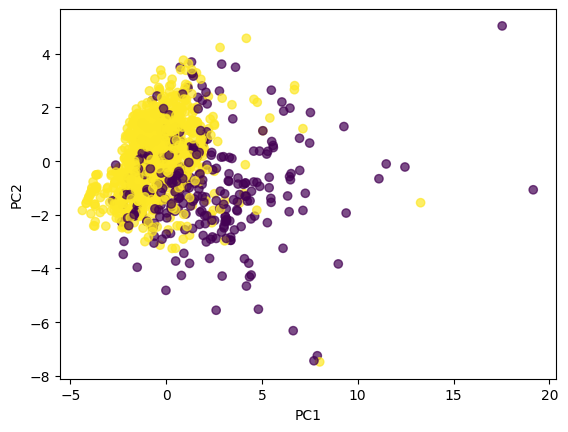

Accuracy: 0.792
Balanced Accuracy: 0.779
F1 score:, 0.856
ROC-AUC: 0.830


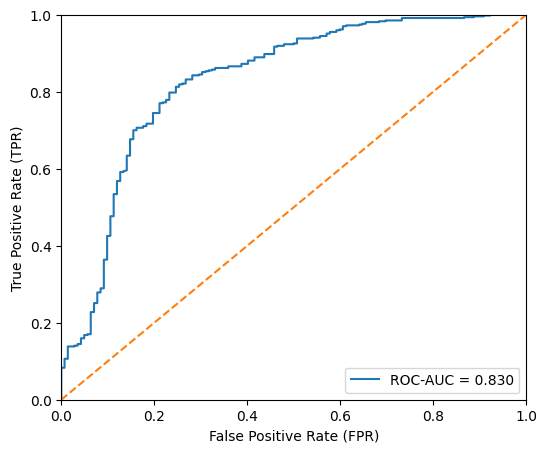

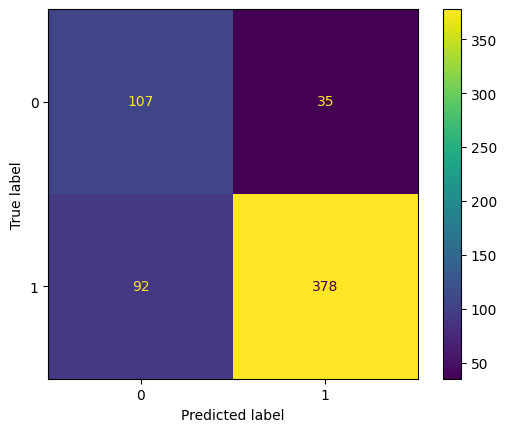

(0.7924836601307189,
 0.7788882229547498,
 0.8561721404303511,
 0.8295100389571473)

In [110]:
pca3 = PCA(n_components=4)
X_train_pca3 = pca3.fit_transform(X_train_scaled)
X_test_pca3 = pca3.transform(X_test_scaled)

plt.scatter(X_train_pca3[:, 0], X_train_pca3[:, 1], c=y_train, alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

lr = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000, random_state=0)
perform_classification(lr, X_train_pca3, X_test_pca3, y_train, y_test)

Accuracy: 0.802
Balanced Accuracy: 0.785
F1 score:, 0.864
ROC-AUC: 0.854


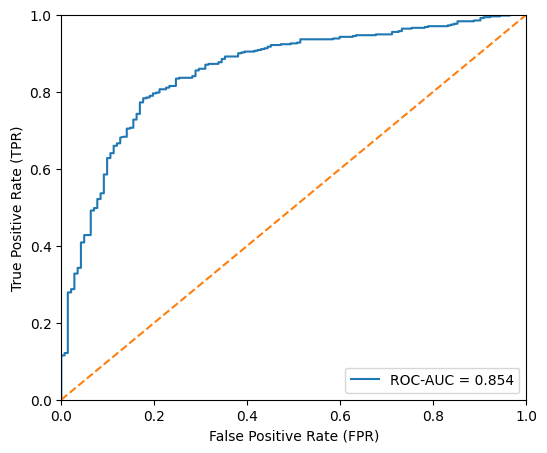

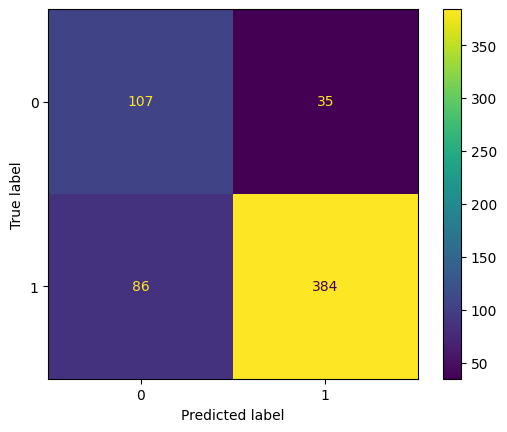

Accuracy: 0.817
Balanced Accuracy: 0.805
F1 score:, 0.874
ROC-AUC: 0.878


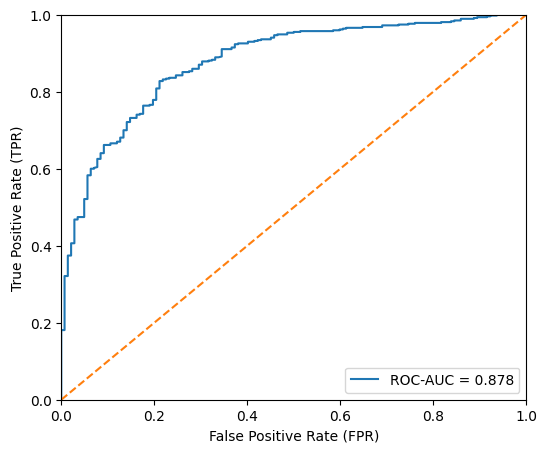

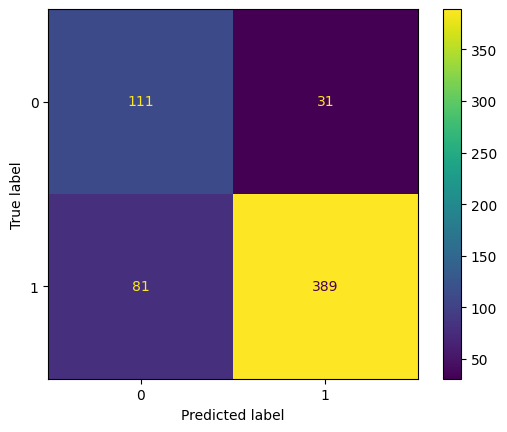

(0.8169934640522876,
 0.8046748576565778,
 0.8741573033707866,
 0.8781690140845071)

In [111]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=0)
perform_classification(svm, X_train_pca3, X_test_pca3, y_train, y_test)
perform_classification(svm, X_train_scaled, X_test_scaled, y_train, y_test)

## MLP

Accuracy: 0.864
Balanced Accuracy: 0.799
F1 score:, 0.913
ROC-AUC: 0.903


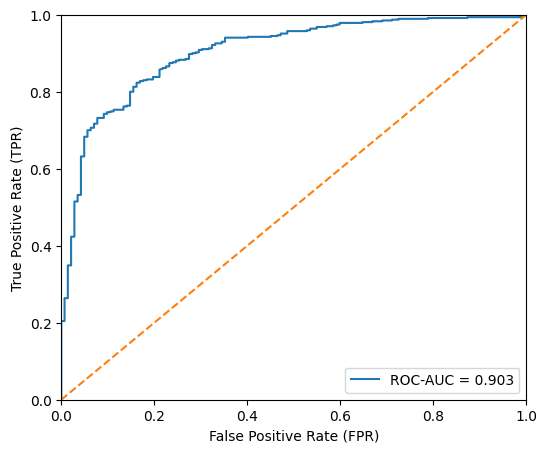

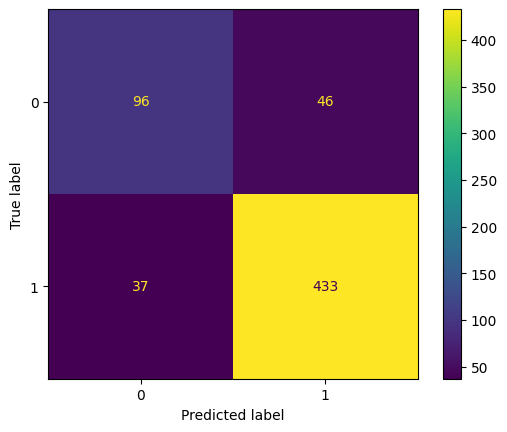

(0.8643790849673203, 0.798666466886425, 0.9125395152792413, 0.9033038657476777)

In [133]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64,32),
    activation='relu',
    solver='adam',
    alpha=0.001,            
    batch_size=32,
    max_iter=1000,
    random_state=0
)

perform_classification(mlp, X_train_scaled, X_test_scaled, y_train, y_test)


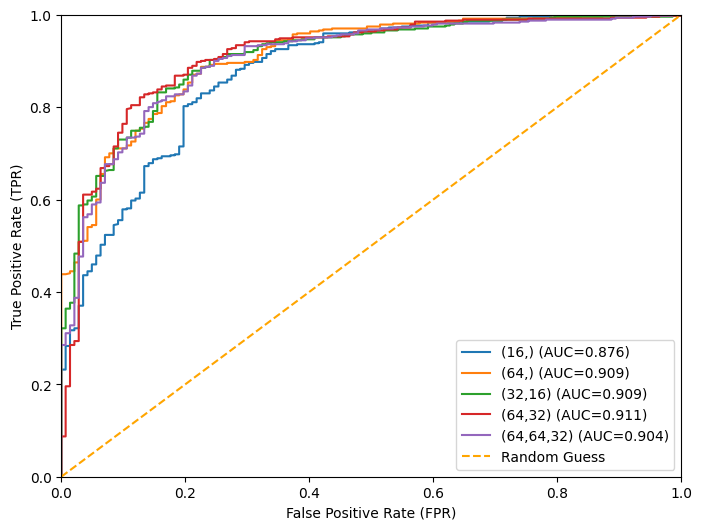

Accuracy: 0.879
Balanced Accuracy: 0.823
F1 score:, 0.922
ROC-AUC: 0.911


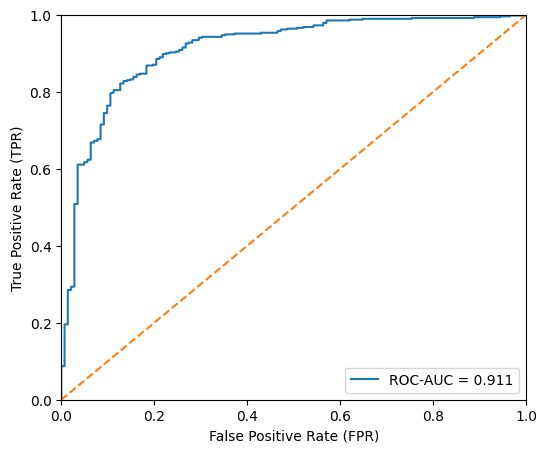

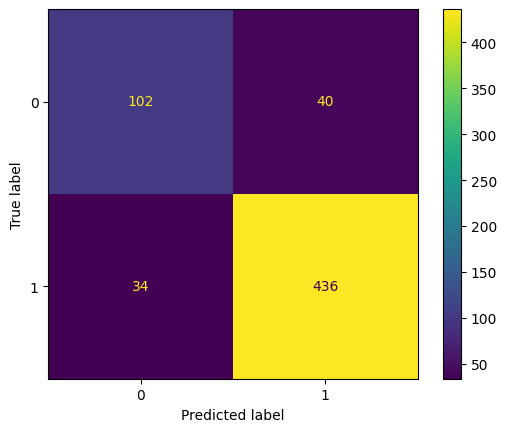

(0.8790849673202614,
 0.8229847168115074,
 0.9217758985200846,
 0.9106607731495355)

In [137]:
models = {
    "(16,)": MLPClassifier(activation='relu', alpha=0.001, hidden_layer_sizes=(16,), max_iter=1000, random_state=0),
    "(64,)": MLPClassifier(activation='relu', alpha=0.001, hidden_layer_sizes=(64,), max_iter=1000, random_state=0),
    "(32,16)": MLPClassifier(activation='relu', alpha=0.001, hidden_layer_sizes=(32,16), max_iter=1000, random_state=0),
    "(64,32)": MLPClassifier(activation='relu', alpha=0.001, hidden_layer_sizes=(64,32), max_iter=1000, random_state=0),
    "(64,64,32)": MLPClassifier(activation='relu', alpha=0.001, hidden_layer_sizes=(64,64,32), max_iter=1000, random_state=0),
}

plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_score = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess', c='orange')
plt.xlim(0, 1); plt.ylim(0, 1)
plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

best_model = models["(64,32)"]

perform_classification(best_model, X_train_scaled, X_test_scaled, y_train, y_test)

,params,mean_test_score
0,"{'hidden_layer_sizes': (16,)}",0.876452
1,"{'hidden_layer_sizes': (32,)}",0.881672
2,"{'hidden_layer_sizes': (64,)}",0.885333
3,"{'hidden_layer_sizes': (32, 16)}",0.861362
4,"{'hidden_layer_sizes': (64, 32)}",0.859510
5,"{'hidden_layer_sizes': (128, 64)}",0.861951
6,"{'hidden_layer_sizes': (64, 32, 16)}",0.859023


Best hidden layer size: (64,)
ROC-AUC: 0.909


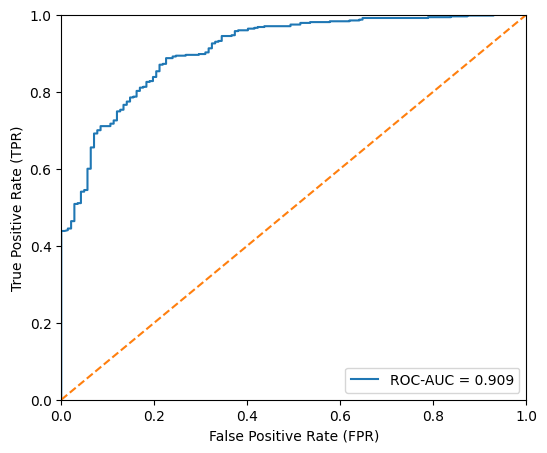

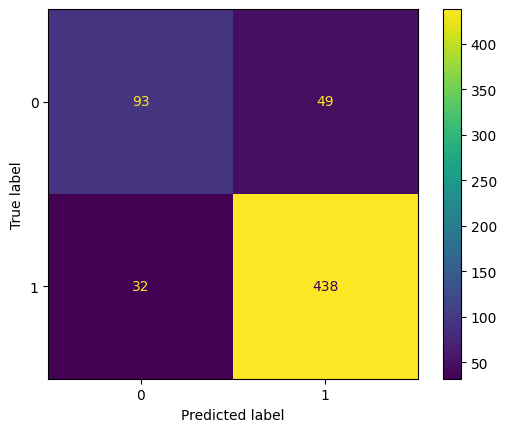

In [ ]:
# alternatively using gridsearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

MLP_size_grid = {'hidden_layer_sizes': [(16,), (32,), (64,), (32,16), (64,32), (128,64), (64,32,16)]}
mlp = MLPClassifier(activation='relu', alpha=0.001, max_iter=1000, random_state=0)
grid = GridSearchCV(MLPClassifier(activation='relu', alpha=0.001, max_iter=1000, random_state=0), MLP_size_grid, scoring='roc_auc', cv=5, n_jobs=-1)
# line search

grid.fit(X_train_scaled, y_train)
grid_cv_results = pd.DataFrame(grid.cv_results_)
display(grid_cv_results[['params', 'mean_test_score']])
best_mlp = grid.best_estimator_
y_pred = best_mlp.predict(X_test_scaled)
y_score = best_mlp.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print("Best hidden layer size:", grid.best_params_['hidden_layer_sizes'])
print(f"ROC-AUC: {roc_auc:.3f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim(0, 1); plt.ylim(0, 1)
plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
plt.legend([f'ROC-AUC = {roc_auc:.3f}'], loc='lower right')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()